# A Healthy ParSplice Cluster
Danny said that a higher temperature would create more activity. He mentioned the `PARPSLICE_TASK_SEGMENT`, `Temperature`, and `InitTemperature` variables in the `ps-config.xml` configuration file for the LAMMPS engine that ParSplice uses. He suggested starting with a temperature of 2000 and an initial temperature of 400; then increasing from there. In this notebook, we try parameters sweeps on a 10 node [CloudLab](https://www.cloudlab.us/) cluster (each node has 36 cores and 64GB of RAM).

In [1]:
from helpers import *
%matplotlib inline

## Experiment: Invert Temperatures
In the nomenclature below, `t` is temperature and `it` is initial temperature. According to Danny:

> "Increasing the temperature will lead to more transitions, and hence more activity in the database (see the section PARSPLICE_TASK_SEGMENT and look for Temperature and InitTemperature). Temperature at 2000 and InitTemperature at 400 should give you relatively frequent transitions. You can increase even more as needed."

We start with the default ParSplice configuration (`t1000it2000`), then try what Danny suggested (`t2000it400`), then for fun we invert it (`t400it200`).

In [2]:
results = ["results-t1000it2000.xml-dbfix",
           "results-t1000it2000.xml-dbfix-rebaseline",
           "results-t1000it2000.xml-dbfix-rebaseline-sweep",
           "results-t2000it400.xml-dbfix",
           "results-t2000it400.xml-dbfix-rebaseline-sweep",
           "results-t400it2000.xml-dbfix",
           "results-t400it2000.xml-dbfix-rebaseline-sweep"]

### Overall Health (`times.out`)
These lines should be linear. One tool to make sure the system is healthy is the `times.out` file produced by ParSplice. The relationship between wall clock time and trajectory duration should be linear because it means the system is keeping up with the simulation load and is mirroring real time. According to Danny:
> "In an ideal case, the trajectory length would proportional to the wall-clock time. Of course, seeing a linear trend alone does not tell you that you are running at the optimal simulation rate  (given by the slope), but usually a nice straight line means you are."

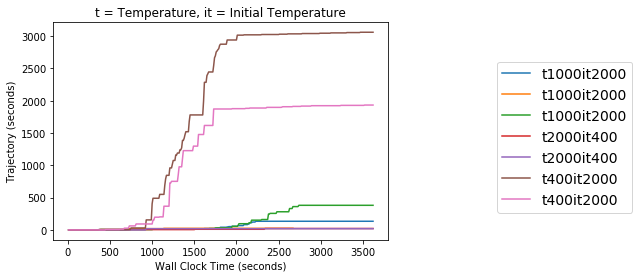

In [3]:
plot_times(results)

Interestingly enough, `t400it2000` produces the steepest, "healthy" curve, while the higher temperatures are much slower.

### LevelDB Performance Counters
In the graphs below, we plot the activity on the persistent DB for one of each run:

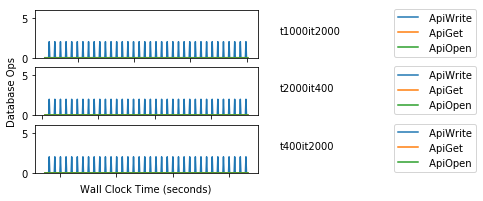

In [4]:
results = ["results-t1000it2000.xml-dbfix-rebaseline-sweep",
           "results-t2000it400.xml-dbfix-rebaseline-sweep",
           "results-t400it2000.xml-dbfix-rebaseline-sweep"]
plot_dbactivity(results, dbnode='node-1')

This does not look right. We only see writes and they are not that frequent. There is definitely not a correlation between the temperature and the number of database operations.

### ParSplice Performance Counters

Finally, we can take a look at the performance counters we added to ParSplice. We look at the in-memory database operations. Recall that this database is just an STL C++ unordered map that sits in front of the persistent database.

results-t1000it2000.xml-dbfix-rebaseline-sweep results-t2000it400.xml-dbfix-rebaseline-sweep results-t400it2000.xml-dbfix-rebaseline-sweep


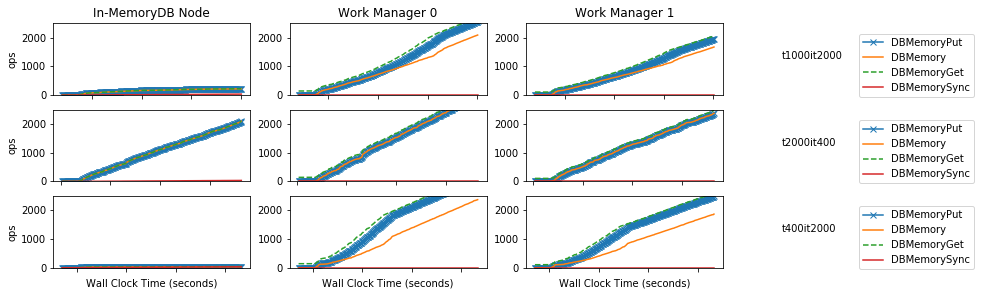

In [5]:
plot_psactivity_sweep(results)
plt.savefig('parsplice-memory-utilization.png', dpi=400, bbox_inches='tight')

This aligns more with what Danny said. We see the work managers servicing a lot of the requests. It looks like higher temperatures causes more activity on the in-memory DB. 
- how much "better" is it to keep all the coordinates on the work managers?
- are the requests to the in-memory DB because the work managers are full **or** because they are cache misses?

## Resource Utilization

To generate these graphs, you have to dump the database collecting the results and parse it into a CSV. You have to run the following:

```bash
for r in \
  "results-t1000it2000.xml-dbfix-rebaseline-sweep" \
  "results-t2000it400.xml-dbfix-rebaseline-sweep" \
  "results-t400it2000.xml-dbfix-rebaseline-sweep"; do
    ./prepare.sh $r; mv tmp tmp-$r
done
```

It takes about 10 minutes on my Mac.

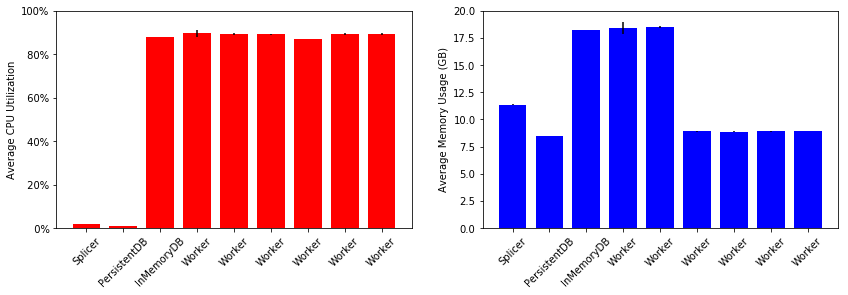

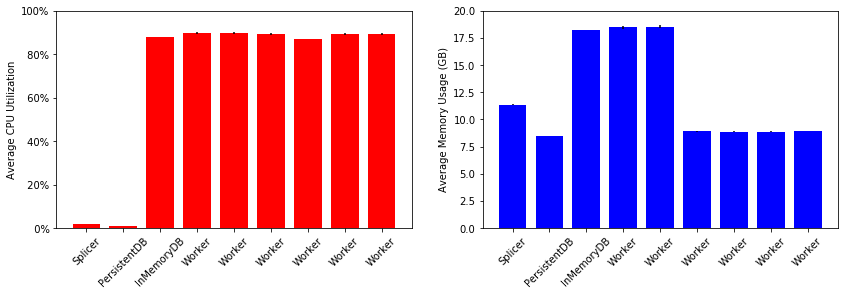

In [6]:
plot_bar_cpu("tmp-results-t1000it2000.xml-dbfix-rebaseline-sweep")
plot_bar_cpu("tmp-results-t2000it400.xml-dbfix-rebaseline-sweep")
plt.savefig('parsplice-resource-utilization.png', dpi=400, bbox_inches='tight')

These are virtually identical... 

## More ParSplice Counters

results-t1000it2000.xml-dbfix-rebaseline-sweep results-t2000it400.xml-dbfix-rebaseline-sweep results-t400it2000.xml-dbfix-rebaseline-sweep


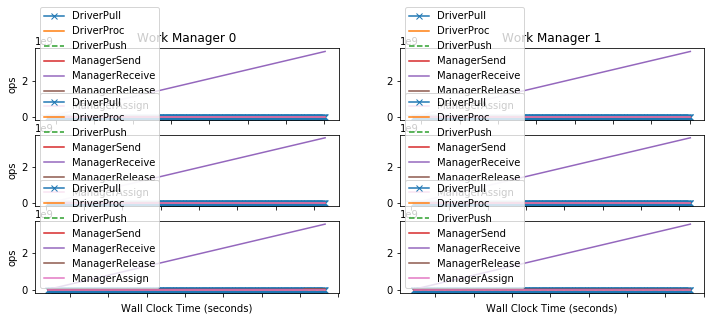

In [7]:
def plot_other_psactivity(results, ylim=6):
    nodesofinterest = [3, 4]
    fig, ax = plt.subplots(len(results), 2, figsize=(12, 1.5*len(results)))
    for i in range(0, len(results)):
        print results[i], 
        for j in range(0, len(nodesofinterest)):
            # ingest and process
            try: shutil.rmtree("tmp")
            except: pass
            fname = "../" + results[i] + "/node-" + str(nodesofinterest[j]) + "/parsplice-logs.tar.gz"
            tar = tarfile.open(fname)
            tar.extractall()
            tar.close()
            df = pd.DataFrame()
            perfdumps = glob.glob("tmp/parsplice-logs/perf*")
            for p in perfdumps:
                d = pd.read_csv(p, index_col=False, names=["op", "count", "time"])
                t = d["time"][0]
                d = d[["op", "count"]]
                d = pd.pivot_table(d, columns=["op"])
                d = d.reset_index()
                d = d.drop('index', axis=1)
                d["time"] = t
                df = df.append(d)
                df = df.sort_values("time")
            ax[i][j].plot(df["time"], df["DriverPull"], marker='x')
            ax[i][j].plot(df["time"], df["DriverProc"])
            ax[i][j].plot(df["time"], df["DriverPush"], ls='--')
            ax[i][j].plot(df["time"], df["ManagerSend"])
            ax[i][j].plot(df["time"], df["ManagerReceive"])
            ax[i][j].plot(df["time"], df["ManagerRelease"])
            ax[i][j].plot(df["time"], df["ManagerAssign"])

            # labels/axis: xticks don't make sense since its unix timestamped
            ax[i][j].set_xticklabels([])
            ax[i][j].legend()
    # only label the last plot    
    for i in range(0, len(nodesofinterest)):
        ax[len(results)-1][i].set_xlabel("Wall Clock Time (seconds)")
    for i in range(0, len(results)):
        ax[i][0].set_ylabel("ops")
    ax[0][0].set_title("Work Manager 0")
    ax[0][1].set_title("Work Manager 1")

plot_other_psactivity(results)